In [59]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score


from root_numpy import root2array, rec2array

from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [60]:
def load(sig_filename, bkg_filename, category, features):

    features = [c.strip() for c in features]
    features = (b.replace(" ", "_") for b in features)
    features = list(b.replace("-", "_") for b in features)

    signal = root2array(sig_filename, category, features)
    signal = rec2array(signal)

    backgr = root2array(bkg_filename, category, features)
    backgr = rec2array(backgr)

    # for sklearn data is usually organised
    # into one 2D array of shape (n_samples x n_features)
    # containing all the data and one array of categories
    # of length n_samples
    X = np.concatenate((signal, backgr))
    y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

    return X,y


In [61]:
# List selected features (i.v. variables)
branch_names = """mass_tag_tag_min_deltaR,median_mass_jet_jet,maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,centrality_jets_leps,centrality_tags""".split(",")


In [62]:
# Load data
X, y = load("combined/signalData.root", "combined/backgroundData.root", "event_mvaVariables_step7_cate4", branch_names)

In [63]:
# Plotting Variables and Correlations
import pandas.core.common as com
from pandas.core.index import Index

from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

# Create a pandas DataFrame for our data
# this provides many convenience functions
# for exploring your dataset
# need to reshape y so it is a 2D array with one column
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))), columns=branch_names+['y'])


In [64]:
def signal_background(data1, data2, column=None, grid=True,
                      xlabelsize=None, xrot=None, ylabelsize=None,
                      yrot=None, ax=None, sharex=False,
                      sharey=False, figsize=None,
                      layout=None, bins=10, **kwds):
    """Draw histogram of the DataFrame's series comparing the distribution
    in `data1` to `data2`.
    
    data1: DataFrame
    data2: DataFrame
    column: string or sequence
        If passed, will be used to limit data to a subset of columns
    grid : boolean, default True
        Whether to show axis grid lines
    xlabelsize : int, default None
        If specified changes the x-axis label size
    xrot : float, default None
        rotation of x axis labels
    ylabelsize : int, default None
        If specified changes the y-axis label size
    yrot : float, default None
        rotation of y axis labels
    ax : matplotlib axes object, default None
    sharex : bool, if True, the X axis will be shared amongst all subplots.
    sharey : bool, if True, the Y axis will be shared amongst all subplots.
    figsize : tuple
        The size of the figure to create in inches by default
    layout: (optional) a tuple (rows, columns) for the layout of the histograms
    bins: integer, default 10
        Number of histogram bins to be used
    kwds : other plotting keyword arguments
        To be passed to hist function
    """        
        
    if 'alpha' not in kwds:
        kwds['alpha'] = 0.5

    w,h = (12,8)
    figsize=(w,h)

    if column is not None:
        if not isinstance(column, (list, np.ndarray, Index)):
            column = [column]
        data1 = data1[column]
        data2 = data2[column]
        
    data1 = data1._get_numeric_data()
    data2 = data2._get_numeric_data()
    naxes = len(data1.columns)


    fig, axes = plotting._subplots(naxes=naxes, 
                                   ax=ax, 
                                   squeeze=False,
                                   sharex=sharex,
                                   sharey=sharey,
                                   figsize=figsize,
                                   layout=layout)
    _axes = plotting._flatten(axes)

    for i, col in enumerate(com._try_sort(data1.columns)):
        ax = _axes[i]
        low = min(data1[col].min(), data2[col].min())
        high = max(data1[col].max(), data2[col].max())
        ax.hist(data1[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.hist(data2[col].dropna().values,
                bins=bins, range=(low,high), **kwds)
        ax.set_title(col)
        ax.legend(['BKG', 'SIG'], loc='best')
        ax.grid(grid)


    plotting._set_ticks_props(axes, xlabelsize=xlabelsize, xrot=xrot,
                              ylabelsize=ylabelsize, yrot=yrot)
    fig.subplots_adjust(wspace=0.4, hspace=0.8)

    return axes


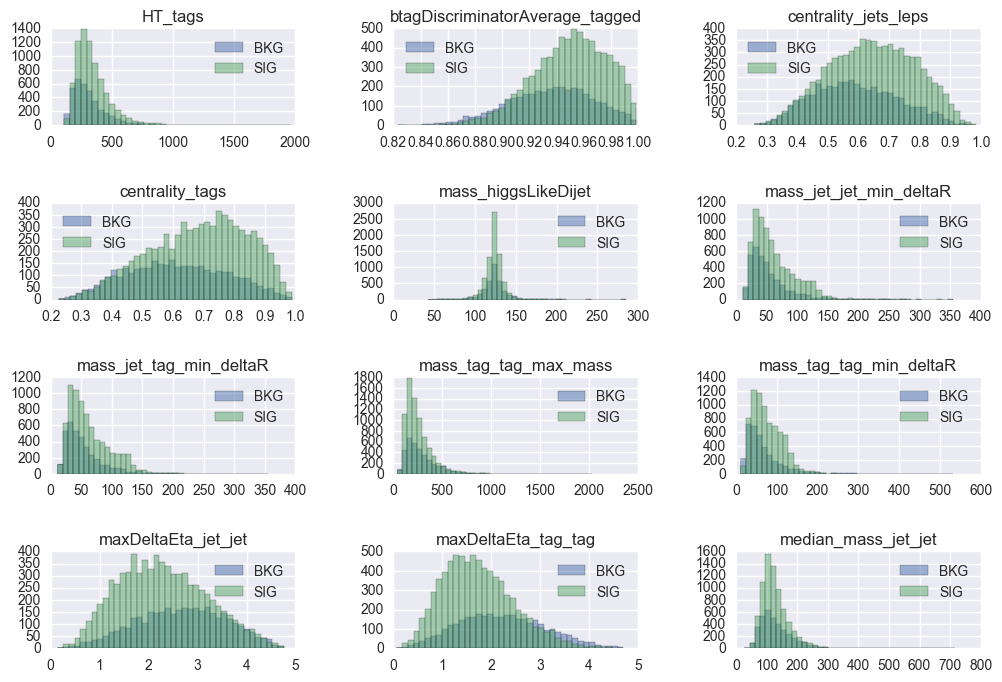

In [65]:
# Plot signal and background distributions for some
# variables
# The first two arguments select what is "signal"
# and what is "background". This means you can
# use it for more general comparisons of two
# subsets as well.
signal_background(df[df.y<0.5], df[df.y>0.5],
                  column=["mass_tag_tag_min_deltaR",
                          "median_mass_jet_jet",
                          "maxDeltaEta_tag_tag",
                          "mass_higgsLikeDijet",
                          "HT_tags",
                          "btagDiscriminatorAverage_tagged",
                          "mass_jet_tag_min_deltaR",
                          "mass_jet_jet_min_deltaR",
                          "mass_tag_tag_max_mass",
                          "maxDeltaEta_jet_jet",
                          "centrality_jets_leps",
                          "centrality_tags"],
                  bins=40)

plt.show()

In [66]:
# Correlation Matrix
bg = df.y < 0.5
sig = df.y > 0.5

def correlations(data, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    if data.y.any() > 0.5:
        label = "signal"
    elif data.y.any() < 0.5:
        label = "background"

    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    data = data.drop('y', 1)
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(8,7)) # figsize=(6,5)
    
    opts = {'cmap': plt.get_cmap('Blues', 20),
            'vmin': -1, 'vmax': +1}

    ax1.set_title("Correlations: " + label)

    sns.heatmap(df.drop('y', axis=1).corr(method='spearman'), annot=True, ax=ax1, vmin=0, vmax=1, annot_kws={"size": 8}, cmap = plt.get_cmap('Blues', 20)) 

    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    labels = corrmat.columns.values

    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(np.flipud(labels), minor=False)
        
    plt.tight_layout()
    #return plt.show()

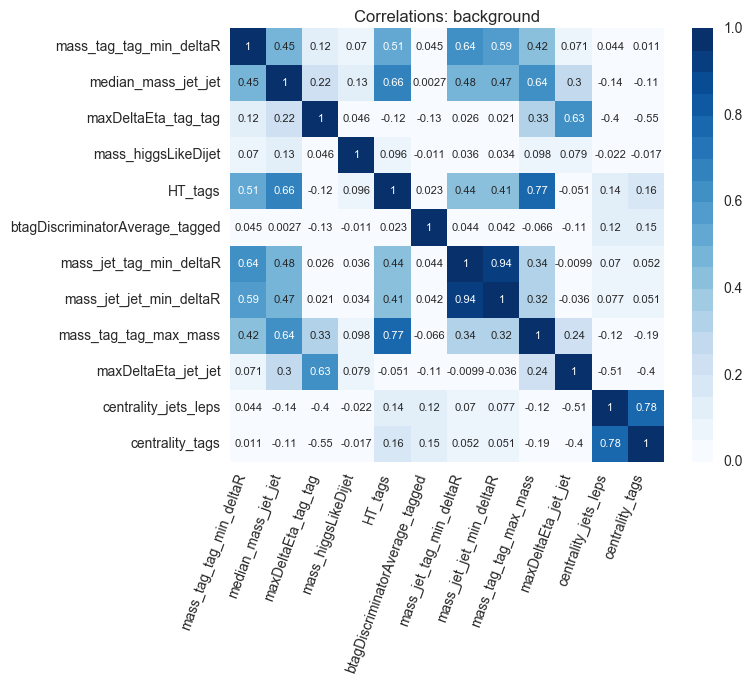

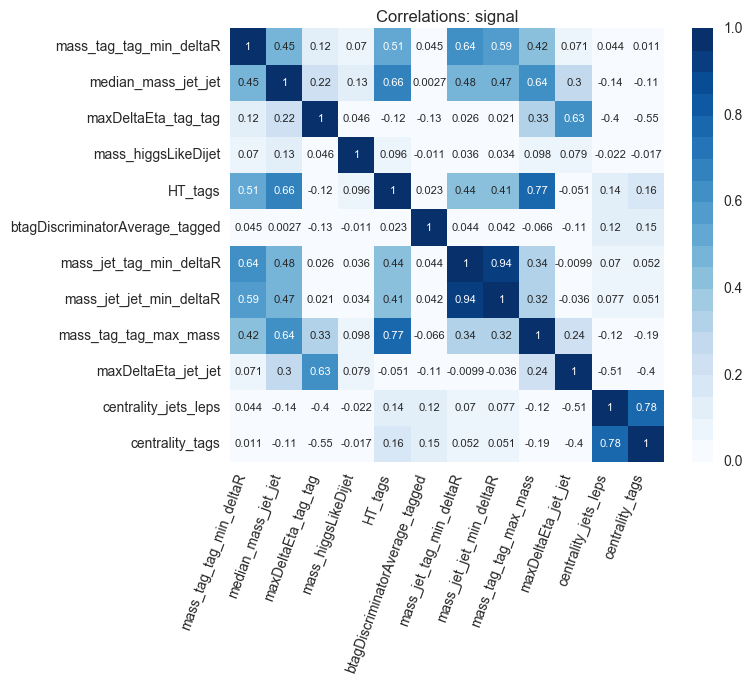

In [67]:
# remove the y column from the correlation matrix
# after using it to select background and signal
correlations(df[bg])
correlations(df[sig]) 
plt.show()

In [68]:
# set aside an evaluation sample
# We artificially limit ourselves
# to a small subset of the available
# samples. This speeds things up and
# makes it easier to illustrate things
# like over-fitting. In real life you
# would not do this.
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, train_size=5967, test_size=3978, random_state=42)


In [69]:
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import GradientBoostingClassifier

# Example classifier with randome hyper-parameter setting (non-optimized)
#model = GradientBoostingClassifier(n_estimators=200,
#                                   max_depth=1,
#                                   subsample=0.5,
#                                   max_features=0.5,
#                                   learning_rate=0.02)

model = GradientBoostingClassifier(loss= 'exponential',
                                   min_impurity_split= 1e-07,
                                   learning_rate= 0.025,
                                   min_samples_leaf= 0.05,
                                   n_estimators= 300,
                                   subsample= 0.55,
                                   min_weight_fraction_leaf= 0.0,
                                   min_samples_split= 2,
                                   max_depth= 3)

In [70]:
# Grid search of hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# Split development set into a train and test samplee
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=4685)

# Assessing a Classifier's Performance
model.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=0.05,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=0.55, verbose=0, warm_start=False)

In [71]:
#Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and area under the curve 
def roc_plot(model, X, y):

    decisions = model.decision_function(X)
    print "\nArea under ROC curve: %.4f"%(roc_auc_score(y,decisions))

    scores = cross_val_score(model, X, y, scoring="roc_auc", n_jobs=-1, cv=5)
    print "AUC ROC accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

    # Assessing a Classifier's Performance
    y_predicted = model.predict(X)
    print classification_report(y, y_predicted, target_names=["background", "signal"])

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions)
    roc_auc = auc(fpr, tpr)

    plt.subplot(111, axisbg='white')
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

    #plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.plot([0, 1], [0, 1], '--', color=(0.1, 0.1, 0.1), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Background Rejection Rate (False Positive Rate)')
    plt.ylabel('Signal Efficiency Rate (True Positive Rate)')
    plt.title('Receiver operating characteristic')
    #plt.legend(loc="lower right")

    leg = plt.legend(loc="lower right", frameon=True, fancybox=True, fontsize=12)
    frame = leg.get_frame()
    frame.set_facecolor('White')
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    #plt.show()



Area under ROC curve: 0.7611
AUC ROC accuracy: 0.75914 (+/- 0.02626)
             precision    recall  f1-score   support

 background       0.68      0.44      0.54       652
     signal       0.77      0.90      0.83      1318

avg / total       0.74      0.75      0.73      1970



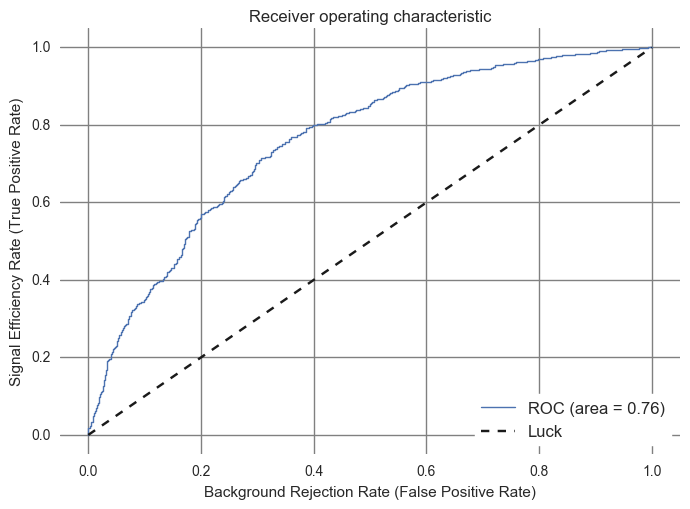

In [72]:
roc_plot(model, X_test, y_test)
plt.show()

In [73]:
# Split development set into a train and test samplee
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=4685)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.025, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=0.05,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=0.55, verbose=0, warm_start=False)

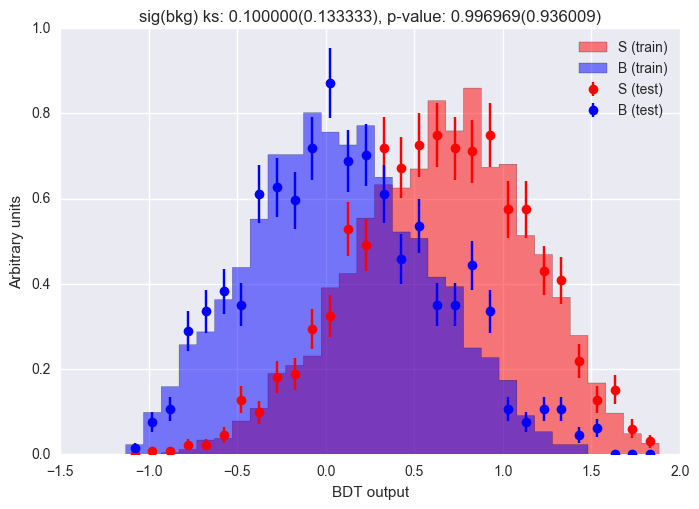

In [74]:
from scipy.stats import ks_2samp

# Overtraining Check
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):

    # use subplot to extract axis to add ks and p-value to plot
    fig, ax = plt.subplots()

    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', normed=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    # Define signal and background histograms for training & testing 
    hist_sig_train, bins = np.histogram(decisions[0],  bins=bins, range=low_high, normed=True)
    hist_bkg_train, bins = np.histogram(decisions[1],  bins=bins, range=low_high, normed=True)

    hist_sig_test, bins = np.histogram(decisions[2], bins=bins, range=low_high, normed=True)
    hist_bkg_test, bins = np.histogram(decisions[3], bins=bins, range=low_high, normed=True)

    # Estimate ks-test and p-values as an indicator of overtraining of fit model
    s_ks, s_pv = ks_2samp(hist_sig_train, hist_sig_test)
    b_ks, b_pv = ks_2samp(hist_bkg_train, hist_bkg_test)

    ax.set_title("sig(bkg) ks: %f(%f), p-value: %f(%f)" % (s_ks, b_ks, s_pv, b_pv))

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')

compare_train_test(model, X_train, y_train, X_test, y_test)
plt.show()

In [75]:
def validation_curve(clfs, train, test):
    X_test, y_test = test
    X_train, y_train = train
    
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)

        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)

    plt.legend(loc='best')
    plt.show()

In [76]:
# set aside an evaluation sample
# We artificially limit ourselves
# to a small subset of the available
# samples. This speeds things up and
# makes it easier to illustrate things
# like over-fitting. In real life you
# would not do this.
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, train_size=5967, test_size=3978, random_state=42)

# Split development set into a train and test samplee
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.33, random_state=4685)

In [77]:
clfs = []
params = ((1.,1), (1.,4), (0.2,1), (0.2,4))

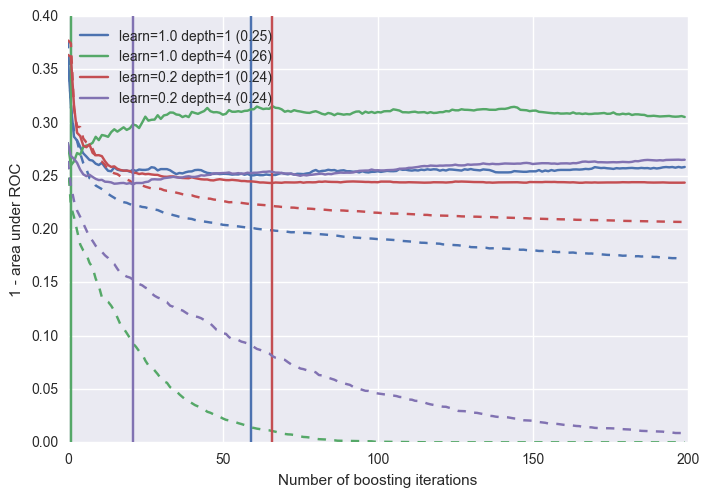

In [78]:
for learn,depth in params:
    gbt_clf = GradientBoostingClassifier(max_depth=depth,
                                         learning_rate=learn,
                                         n_estimators=200)
    gbt_clf.fit(X_train, y_train)
    clfs.append(gbt_clf)

validation_curve(clfs, (X_train,y_train), (X_test,y_test))

In [79]:
# Learning curves
from sklearn.model_selection import learning_curve

# Taken more or less straight from
# http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None, ax=None, xlabel=True):
    if ax is None:
        plt.figure()
        ax.title(title)
    
    if xlabel:
        ax.set_xlabel("Training examples")
        
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    ax.set_ylim([0.65, 1.0])
    return plt

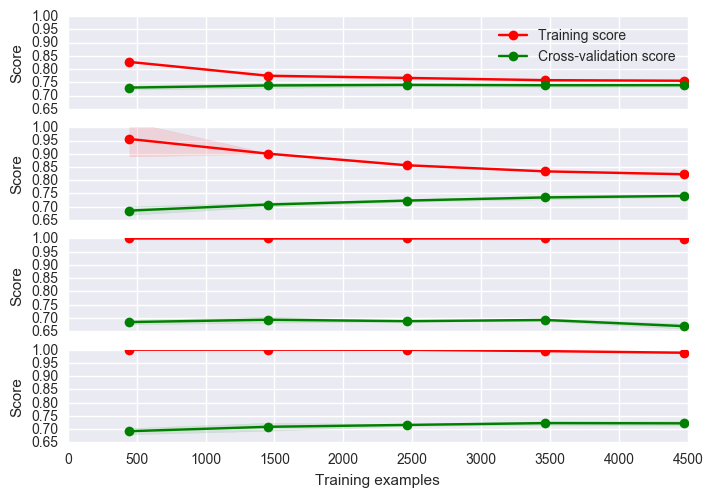

In [80]:
simpleton = GradientBoostingClassifier(max_depth=1,
                                       learning_rate=0.1,
                                       n_estimators=50)
classifiers = [simpleton, clfs[0], clfs[1], clfs[3]]

fig, axes = plt.subplots(nrows=len(classifiers), sharex=True)

for clf, ax in zip(classifiers, axes):  
    plot_learning_curve(clf,
                        "Learning curves",
                        X_dev, y_dev,
                        scoring='roc_auc',
                        n_jobs=7, cv=4,
                        ax=ax, xlabel=False)
    
axes[0].legend(loc="best")
axes[-1].set_xlabel("Training examples")
plt.show()

In [81]:
# Removing features with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8))) # has removed the first column, which has a probability p = 5/6 > .8 of containing a zero.
sel.fit_transform(X)
#print "The variances for each column ", sel.variances_
dictionaryName={}
for i in xrange(len(sel.variances_)):
    dictionaryName[branch_names[i]] = sel.variances_[i]

diction = {}
# summarize selected features
print("\nFeature ranking based on variance:")
for i, (key, value) in enumerate(sorted(dictionaryName.iteritems(), key=lambda (k,v): (v,k),reverse=True)):
     print("%d. %s (%f)" % (i + 1, key, value))



Feature ranking based on variance:
1. mass_tag_tag_max_mass (23427.782430)
2. HT_tags (20750.756522)
3. median_mass_jet_jet (2505.333249)
4. mass_tag_tag_min_deltaR (1685.044397)
5. mass_jet_tag_min_deltaR (1189.856066)
6. mass_jet_jet_min_deltaR (1177.372024)
7. mass_higgsLikeDijet (144.706779)
8. maxDeltaEta_jet_jet (0.845300)
9. maxDeltaEta_tag_tag (0.663567)
10. centrality_tags (0.026481)
11. centrality_jets_leps (0.019946)
12. btagDiscriminatorAverage_tagged (0.000849)


In [82]:
# Univariate feature selection (works by selecting the best features based on univariate statistical tests.)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# perform a chi^2 test to the samples to retrieve only the "n" best features as follows:
# feature extraction
test = SelectKBest(score_func=chi2, k=8) #k=8
fit = test.fit(X, y)
# summarize scores
#print("summarize scores: ",fit.scores_)
#features = fit.transform(X)

dictionaryName={}
for i in xrange(len(fit.scores_)):
    dictionaryName[branch_names[i]] = fit.scores_[i]

diction = {}
# summarize selected features
print("\nFeature ranking based on chi^2 test:")
for i, (key, value) in enumerate(sorted(dictionaryName.iteritems(), key=lambda (k,v): (v,k),reverse=True)): 
     print("%d. %s (%f)" % (i + 1, key, value))



Feature ranking based on chi^2 test:
1. mass_tag_tag_max_mass (12568.648021)
2. HT_tags (4139.532885)
3. mass_jet_tag_min_deltaR (3241.732278)
4. mass_jet_jet_min_deltaR (3230.374377)
5. mass_tag_tag_min_deltaR (3119.814576)
6. maxDeltaEta_tag_tag (299.643072)
7. median_mass_jet_jet (241.596626)
8. maxDeltaEta_jet_jet (152.145087)
9. centrality_tags (19.327061)
10. centrality_jets_leps (11.448559)
11. mass_higgsLikeDijet (3.140550)
12. btagDiscriminatorAverage_tagged (0.528427)


In [83]:


#features = transformer.fit_transform(X, y)

#  Recursive feature elimination
# - http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
# Create the RFE object and rank each feature
from sklearn.feature_selection import RFE

# create the RFE model and select 8 attributes
rfe = RFE(estimator=AdaBoostClassifier(), n_features_to_select=8, step=1) #n_features_to_select=8
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(X[0].shape)

# summarize the selection of the attributes
#print("support ",rfe.support_)
#print("ranking ",rfe.ranking_)

dictionaryName={}
for i in xrange(len(rfe.ranking_)):
    dictionaryName[branch_names[i]] = rfe.ranking_[i]

diction = {}
# summarize selected features
print("\nFeature ranking based on recursive feature elimination (RFE):")
for i, (key, value) in enumerate(sorted(dictionaryName.iteritems(), key=lambda (k,v): (v,k),reverse=True)):
     print("%d. %s (%f)" % (i + 1, key, value))



Feature ranking based on recursive feature elimination (RFE):
1. centrality_tags (5.000000)
2. median_mass_jet_jet (4.000000)
3. mass_jet_jet_min_deltaR (3.000000)
4. maxDeltaEta_jet_jet (2.000000)
5. maxDeltaEta_tag_tag (1.000000)
6. mass_tag_tag_min_deltaR (1.000000)
7. mass_tag_tag_max_mass (1.000000)
8. mass_jet_tag_min_deltaR (1.000000)
9. mass_higgsLikeDijet (1.000000)
10. centrality_jets_leps (1.000000)
11. btagDiscriminatorAverage_tagged (1.000000)
12. HT_tags (1.000000)



Feature ranking based on random forest feature importance:
1. maxDeltaEta_tag_tag (0.107823)
2. btagDiscriminatorAverage_tagged (0.103472)
3. mass_tag_tag_min_deltaR (0.090538)
4. centrality_tags (0.084565)
5. maxDeltaEta_jet_jet (0.082200)
6. mass_higgsLikeDijet (0.081662)
7. centrality_jets_leps (0.077211)
8. mass_tag_tag_max_mass (0.077140)
9. HT_tags (0.075825)
10. median_mass_jet_jet (0.073783)
11. mass_jet_tag_min_deltaR (0.073310)
12. mass_jet_jet_min_deltaR (0.072472)


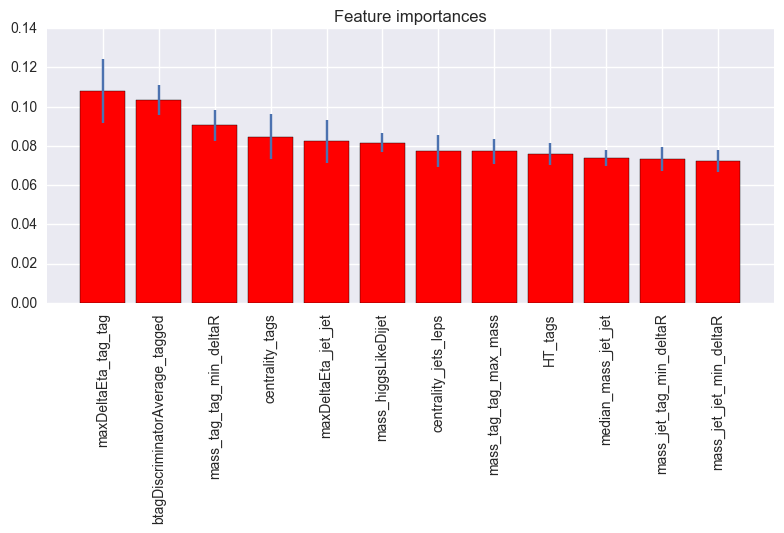

In [84]:
# Feature importances with forests of trees
# - http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import matplotlib as mpl

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking (relative importance of each attribute)
print("\nFeature ranking based on random forest feature importance:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, df.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the model
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


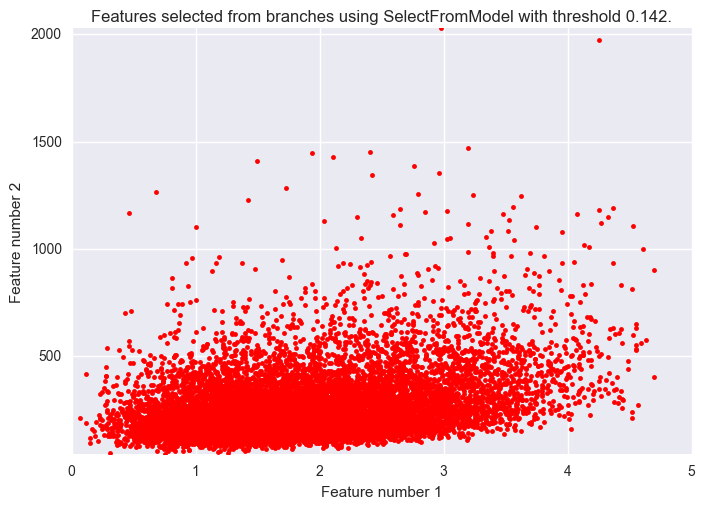

In [85]:
# Feature selection methods can give you useful information on the relative importance or relevance of features for a given problem.

# Feature selection using SelectFromModel
#The features are considered unimportant and removed, if the feature_importances_ values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. Available heuristics are "mean", "median" and float multiples of these like "0.1*mean".
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

# Set a minimum threshold of 0.001
clf = AdaBoostClassifier()
sfm = SelectFromModel(clf, threshold=0.001) #0.25
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.003 #0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title("Features selected from branches using SelectFromModel with threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()


In [86]:
# Tree-based feature selection
#Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
#print clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(11190, 4)

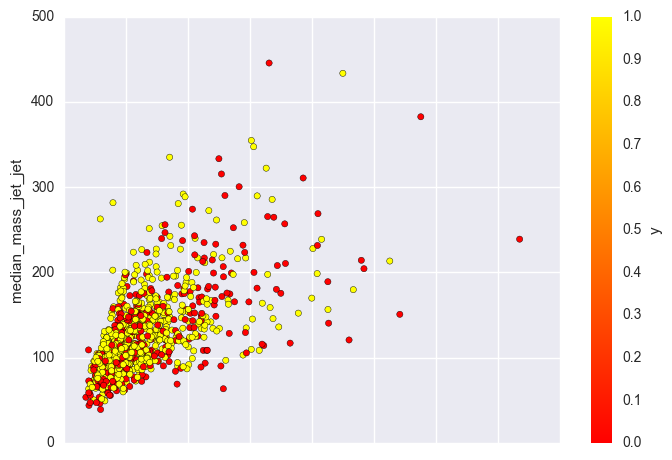

In [90]:
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index

# Scatter Plots                                                                                                               
df.ix[random.sample(df.index, 1000)].plot(kind='scatter',
                                          x='mass_tag_tag_max_mass', 
                                          y='median_mass_jet_jet',
                                          c='y',
                                          cmap='autumn')
plt.show()

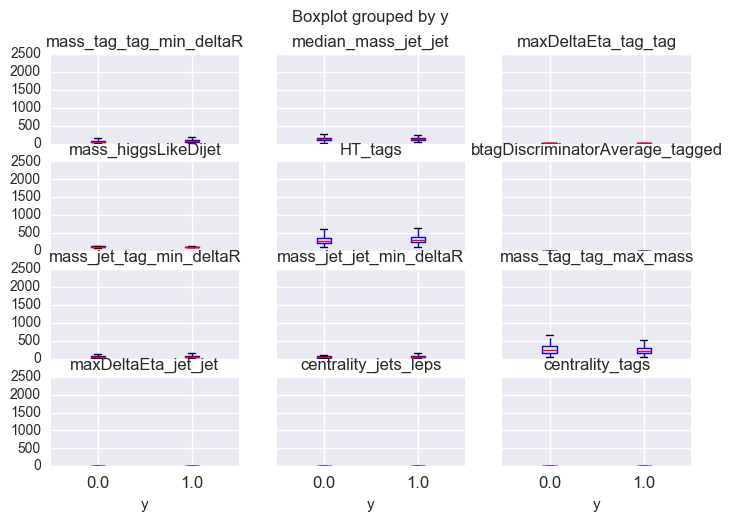

In [88]:
# Boxplots                                                                                                              
df.boxplot(by='y',
           column=["mass_tag_tag_min_deltaR",
                   "median_mass_jet_jet",
                   "maxDeltaEta_tag_tag",
                   "mass_higgsLikeDijet",
                   "HT_tags",
                   "btagDiscriminatorAverage_tagged",
                   "mass_jet_tag_min_deltaR",
                   "mass_jet_jet_min_deltaR",
                   "mass_tag_tag_max_mass",
                   "maxDeltaEta_jet_jet",
                   "centrality_jets_leps",
                   "centrality_tags"],
           return_type='axes')
plt.show()
